In [15]:
#Shishir Khanal
#PID Controller design in Julia
#https://dewdotninja.github.io/julia/control/julia_control.html
using Pkg;
Pkg.add("ControlSystems");
Pkg.add("PlutoUI");
Pkg.add("Plots");
Pkg.add("DSP");
using ControlSystems, PlutoUI, Plots, DSP;

   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`


In [16]:
s = tf("s");
kp = 15;
ki = 10;
kd = 15;

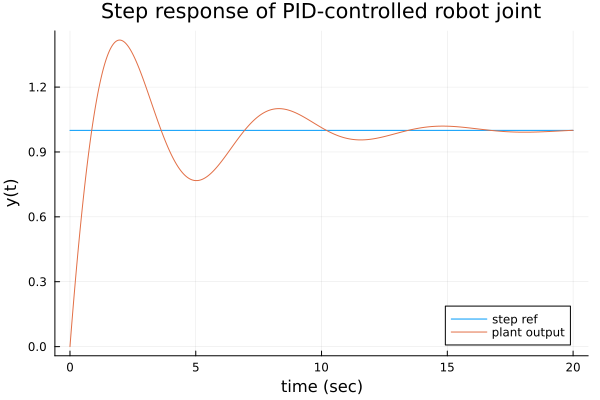

In [17]:
#Step response
begin
    P₁ = 1/(10s^2+0.1s)#Robot-joint plant
    C₁ = kp + ki/s + kd*s; #PID controller in parallel form
    L₁ = C₁*P₁
    T₁ = feedback(L₁)
    tvec₁ = collect(0:0.01:20)
    y₁, t₁, x₁ = step(T₁, tvec₁)
    y₁ = dropdims(y₁,dims=1)
    r₁ = ones(size(t₁))
    plot(t₁,r₁,label="step ref")
    plot!(t₁,y₁, label="plant output",xlabel="time (sec)", ylabel="y(t)",
        title="Step response of PID-controlled robot joint", legend=:bottomright)
end 

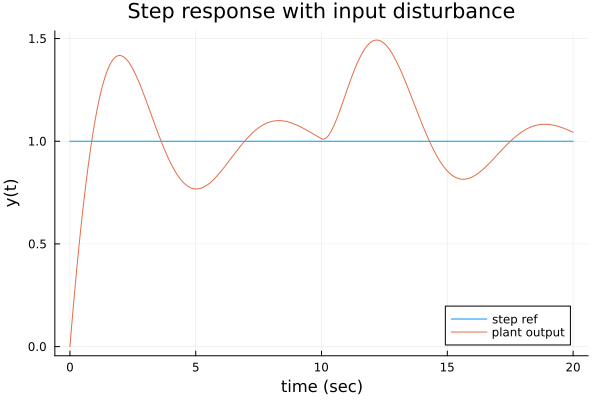

In [18]:
#Step response with input disturbance
begin
    S₁ = minreal(1/(1+L₁))
    PSys = P₁*S₁
    d₁ = 10*ones(size(t₁))
    d₁[1:trunc(Int,length(t₁)/2)] .= 0.0
    d₁ = reshape(d₁,(1,size(d₁)...)) #fix for ControlSystems 1.2.1
    y₂, t₂, x₂ = lsim(PSys,d₁,tvec₁,method=:zoh)
    y₂ = dropdims(y₂,dims=1)
    yₜ = y₁ + y₂
    plot(t₁,r₁,label="step ref")
    plot!(t₂,yₜ, label="plant output",xlabel="time (sec)", ylabel="y(t)",
        title="Step response with input disturbance", legend=:bottomright)
end 

In [19]:
function pid3(P, Kpvec, Kivec, Kdvec, tvec)
    s = tf("s")
    r = ones(size(tvec))
    d = 10*ones(size(tvec))
    d[1:trunc(Int,length(tvec)/2)] .= 0.0
    d = reshape(d,(1,size(d)...)) #fix for ControlSystems 1.2.1
    plot(tvec,r,label="Step ref")
    
    for i in 1:3
        Ci = Kpvec[i] + Kivec[i]/s + Kdvec[i]*s
        L = Ci*P
        T = feedback(L)
        S = minreal(1/(1+L))
        y₁, t₁, x₁ = step(T, tvec)
        y₁ = dropdims(y₁, dims=1)
        Sys = P*S
        y₂, t₂, x₂ = lsim(Sys,d,tvec,method=:zoh)
        y₂ = dropdims(y₂,dims=1)
        
        y = y₁ + y₂
        plot!(tvec,y,label="y"*string(i)*"(t)")
    end
    plot!(xlabel="time (sec)",ylabel="Plant Output", title="Step response with input disturbance", legend=:bottomright)
end

pid3 (generic function with 1 method)

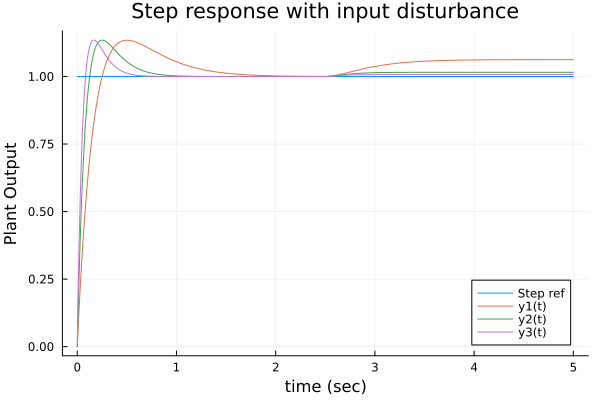

In [20]:
#Pid outputs for various P and D coeffs
begin
    Kpvec = [160, 640, 1440]
    Kdvec = [80, 160, 240]
    Kivec = [0, 0, 0]
    tvec = collect(0:0.01:5)
    pid3(P₁,  Kpvec, Kivec, Kdvec, tvec)
end
#Higher the nat freq, faster the response
#Steady-state error from step response can't be attenuated using PD controller

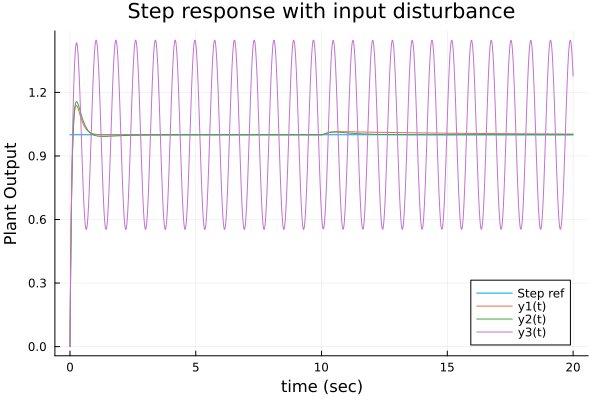

In [21]:
begin
    Kpvec1 = [640, 640, 640]
    Kdvec1 = [160, 160, 160]
    Kivec1 = [100, 600, 10246.4]
    tvec1 = collect(0:0.01:20)
    pid3(P₁,  Kpvec1, Kivec1, Kdvec1, tvec1)
end
#From Routh-Hurwitz, Kp = 640, Kd = 160, Ki = 1024.6 makes the system marginally stable

In [22]:
#PID tuning using Ziegler-Nichols Freq Domain mechanisms
#Turn off Ki and Kd and slowly increase Kp until the plant becomes marginally stable
#Measure the period of oscillation
# Use ZNFD table to tune P, PI, or PID controller

In [23]:
#Lets use LPF after PID
#H(s) = 1 / (0.0016s + 1)

function pid_filter(Kp, Ki, Kd, P, tvec)
    C = (Kd*s^2 + Kp*s + Ki)/(0.0016*s^2 + s)
    L = C*P
    T = feedback(L)
    y,t,x = step(T, tvec)
    y = dropdims(y,dims=1)
    r = ones(size(t))
    plot(t,r,label="Step ref")
    plot!(t,y,label="Plant Output", xlabel="time (sec)",ylabel="y(t)",title="Step response of PID + LPF", legend=:bottomright)
end

pid_filter (generic function with 1 method)

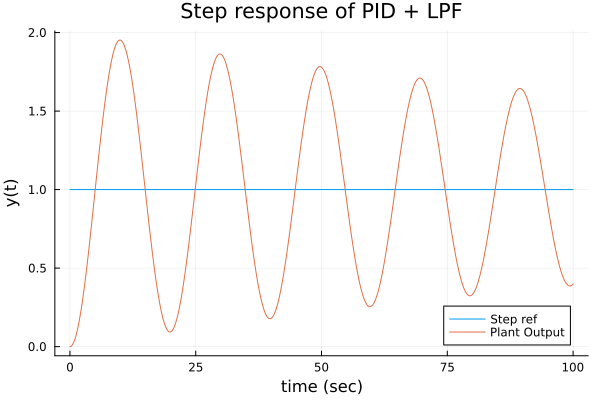

In [24]:
kp2 = 1;
ki2 = 0;
kd2 = 0;
begin
    t_vec = collect(0:0.01:100)
    pid_filter(kp2, ki2, kd2, P₁, t_vec)
end

In [25]:
begin
    C_kp1 = s/(0.0016*s^2 + s)
    L_kp1 = C_kp1*P₁
    wgm, gm, wpm, pm = margin(L_kp1)
    gm
end

1×1 Matrix{Float64}:
 62.521332801153335

In [26]:
#ZNFD table
Kp = 0.6 * gm;
Ki = 1.2 * gm / 8;
Kd = 0.075 * gm * 8;

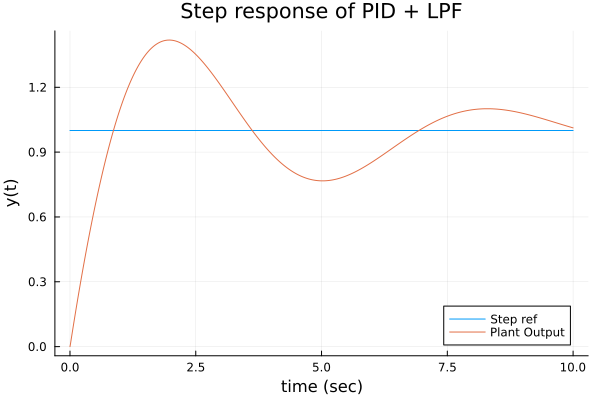

In [27]:
begin
    tvec_zn = collect(0:0.01:10)
    pid_filter(kp, ki, kd, P₁, tvec_zn)
end

# Modified Derivative Term

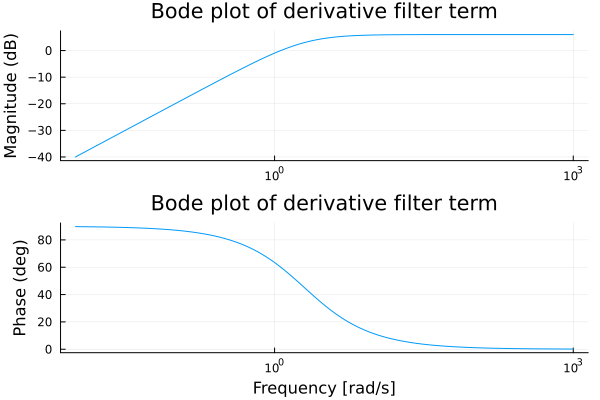

In [29]:
#Derivative Replacement to prevent noise effects
# Replace kd*s with N*Kd / ((N/s) + 1)
N = 2;
k_d = 1;
begin
    Dtf = N*k_d*s/(N + s)
    setPlotScale("dB")
    w = exp10.(LinRange(-2,3,2000))
    bodeplot(Dtf,w; title="Bode plot of derivative filter term", label=false)
end

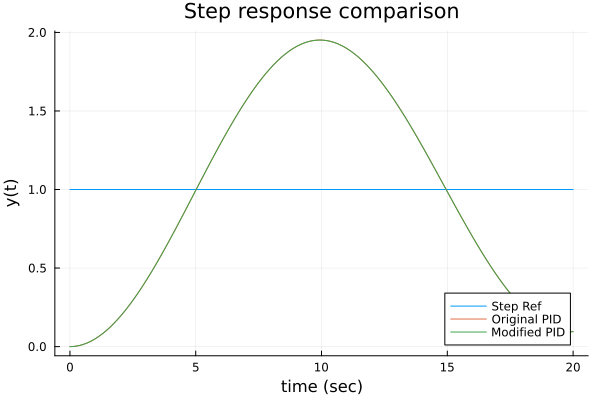

In [39]:
#Compare Step response between original PID and Modified PID
Kp5 = 1.0;
Ki5 = 0.0;
Kd5 = 0.0;
N5 = 2;
begin
    C_orig = Kp5 + Ki5/s + Kd5*s
    C_filt = Kp5 + ki5/s + Kd5*s*N5/(s+N5)
    L_orig = C_orig*P₁
    L_filt = C_filt*P₁
    T_orig = feedback(L_orig)
    T_filt = feedback(L_filt)
    tvec5 = collect(0:0.01:20)
    y_orig,t_orig,x_orig = step(T_orig,tvec5)
    y_filt,t_filt,x_filt = step(T_filt,tvec5)
    y_orig = dropdims(y_orig,dims=1)
    y_filt = dropdims(y_filt,dims=1)
    r5 = ones(size(t_orig))
    plot(tvec5,r5,label="Step Ref")
    plot!(t_orig, y_orig, label="Original PID")
    plot!(t_filt, y_filt, label="Modified PID", xlabel="time (sec)", ylabel="y(t)",
        title="Step response comparison", legend=:bottomright)
end
#Original and Modified Overlap when derivative controller is turned off

# Effect of Saturation

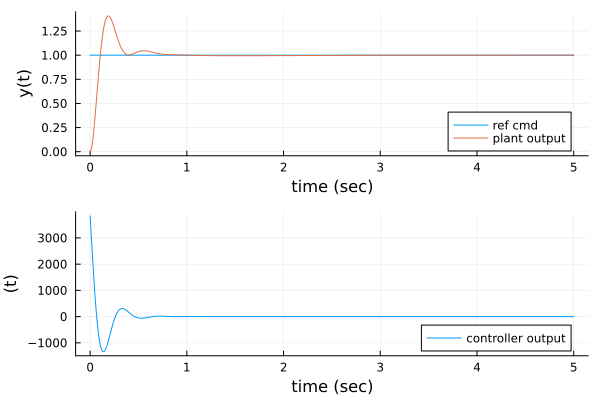

In [71]:

begin
    # P₁ already defined above
    Ts = 0.001 # sampling time
    Pd = c2d(P₁,Ts) # discretize Pd
    Pd_z,Pd_p,Pd_k = zpkdata(Pd)
    Pd_num = [0 real(Pd_k[1]*[1 -Pd_z[1][1]])]
    Pd_den = real(conv([1 -Pd_p[1][1]],[1 -Pd_p[1][2]]))

    K_p = 640
    K_i = 600
    K_d = 160
    N1 = 20
    u_lim = false

    #u_bnd = 50  # controller output limit. Use slider to adjust
    #u_lim = false
    C_pid = K_p + K_i/s + N1*K_d*s/(N1+s)
    Cd_pid = c2d(C_pid,Ts)
    Cd_z, Cd_p, Cd_k = zpkdata(Cd_pid)
    Cd_num = real(Cd_k[1]*conv([1 -Cd_z[1][1]],[1 -Cd_z[1][2]]))
    Cd_den = real(conv([1 -Cd_p[1][1]],[1 -Cd_p[1][2]]))

    t_vec1 = collect(0:Ts:5)
    y_vec = zeros(size(t_vec1))
    e_vec = zeros(size(t_vec1))
    u_vec = zeros(size(t_vec1))
    r_vec = ones(size(t_vec1))
    Pnum_order = length(Pd_num)  # 3
    Pden_order = length(Pd_den)  # 3
    Cnum_order = length(Cd_num)  # 3
    Cden_order = length(Cd_den)  # 3

    # vectors for plant and controller states
    y_prev = zeros(Pden_order)
    u_prev = zeros(Pnum_order) 
    uc_prev = zeros(Cden_order)
    e_prev = zeros(Cnum_order)

    for i in 1:length(t_vec1)
        # controller dynamics
        # controller states update
        for k in 1:Cden_order-1  
            uc_prev[k] = uc_prev[k+1]		
            e_prev[k] = e_prev[k+1]
        end
        if i == 1
            e_vec[i] = r_vec[i]
        else
            e_vec[i] = r_vec[i] - y_vec[i-1]
        end
        e_prev[Cnum_order] = e_vec[i]
        uc = Cd_num[1]*e_vec[i]
        for k in 1:Cden_order-1
            uc = uc+Cd_num[k+1]*e_prev[Cnum_order-k] - Cd_den[k+1]*uc_prev[Cden_order-k]
        end

        # implement output saturation here 
        if u_lim == true
            if uc>u_bnd
                u_vec[i] = u_bnd
            elseif uc<-u_bnd
                u_vec[i] = -u_bnd
            else
                u_vec[i] = uc
            end
        else
                u_vec[i] = uc
        end

        uc_prev[Cden_order] = uc #u_vec[i]

        # plant dynamics
        # plant states update
        for k in 1:Pden_order-1  
            u_prev[k] = u_prev[k+1]		
            y_prev[k] = y_prev[k+1]
        end

        u_prev[Pnum_order] = u_vec[i]
        y_vec[i] = Pd_num[1]*u_vec[i]
        for k in 1:Pden_order-1
            y_vec[i] = y_vec[i]+Pd_num[k+1]*u_prev[Pnum_order-k] - Pd_den[k+1]*y_prev[Pden_order-k]
        end
        y_prev[Pden_order] = y_vec[i]
    end	
    p1=plot(t_vec1, r_vec, label = "ref cmd")
    plot!(t_vec1, y_vec, label = "plant output",xlabel="time (sec)",ylabel="y(t)",legend=:bottomright)
    p2 = plot(t_vec1, u_vec, label = "controller output", xlabel="time (sec)",ylabel="(t)",legend=:bottomright)
    plot(p1,p2, layout=(2,1))


    end

# Anti-windup Scheme, Setpoint weighting, Modified Derivative term w/ PID

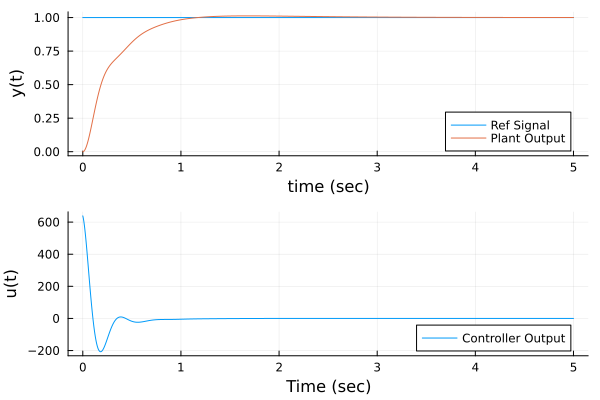

In [74]:
#Assume the industrial servo used for the robot joint allows input voltage in the range ±10 V
#PID with Anti-windup control + Setpoint weighting + Modified Derivative Controller
begin
    y_vec1 = zeros(size(t_vec1))
    e_vec1 = zeros(size(t_vec1))
    u_vec1 = zeros(size(t_vec1))
    uc_vec1 = zeros(size(t_vec1)) # controller output without limit

    ep = 0  # error for proportional term
    e1 = 0  # true error (for integral term)
    e0 = 0
    eus1 = 0 # error for back calculation term 
    eus0 = 0
    ed1 = 0  # error for derivative term
    ed0 = 0
    ui1 = 0  # integral-term outputs
    ui0 = 0
    ud1 = 0  # derivative-term outputs
    ud0 = 0

    # These values are bounded to sliders
    Kp = 640  # PID gains
    Ki = 600
    Kd = 160
    Kt = 0  # back calculaiton gain
    Wp = 0.75  # proportional weight
    Wd = 0.05  # derivative weight
    Nf = 20  # derivative filter coefficient


    #PID_update()
    bi = 0.5*Ts*Ki
    bt = 0.5*Ts*Kt
    ad1 = 1+0.5*Nf*Ts
    ad2 = 0.5*Nf*Ts - 1
    ad = -ad2/ad1
    bd = Kd*Nf/ad1	
    # vectors for plant and controller states
    y_prev1 = zeros(Pden_order)
    u_prev1 = zeros(Pnum_order) 
    
    for i in 1:length(t_vec1)

        e1 = e0
        ed1 = ed0
        eus1 = eus0

        ui1 = ui0
        ud1 = ud0
        r = r_vec[i]
        # compute errors for each term
        if i == 1
            y = 0
        else
            y = y_vec1[i-1]
        end
        e0 = r - y
        e_vec1[i] = e0
        ep0 = Wp*r - y # weighted proportional error
        ed0 = Wd*r - y # weighted derivative error

        up0 = Kp*ep0 # output of P term
        ui0 = ui1 +bi*(e0+e1) + bt*(eus0+eus1) # output of I term
        ud0 = ad*ud1 +bd*(ed0 - ed1) # output of D term
        u = up0 + ui0 + ud0
        u_lim = u
        if ulim_on
            if u > u_bnd1
                eus0 = u_bnd1 - u  # compute error for back calculation term
                u_lim = u_bnd1         # limit u to UMID
            elseif u < -u_bnd1
                eus0 = -u - u_bnd1  # compute error for back calculation term
                u_lim = -u_bnd1         # limit u to -UMID
            end
        end
        u_vec1[i] = u_lim
        uc_vec1[i] = u

        # plant dynamics
        # plant states update
        for k in 1:Pden_order-1  
            u_prev1[k] = u_prev1[k+1]
            y_prev1[k] = y_prev1[k+1]
        end

        u_prev1[Pnum_order] = u_vec1[i]
        y_vec1[i] = Pd_num[1]*u_vec1[i]
        for k in 1:Pden_order-1
            y_vec1[i] = y_vec1[i]+Pd_num[k+1]*u_prev1[Pnum_order-k] - Pd_den[k+1]*y_prev1[Pden_order-k]
        end
        y_prev1[Pden_order] = y_vec1[i]
    end	
    p11=plot(t_vec1, r_vec, label = "Ref Signal")
    plot!(t_vec1, y_vec1, label = "Plant Output",xlabel="time (sec)",ylabel="y(t)",legend=:bottomright)
    p21 = plot(t_vec1, u_vec1, label = "Controller Output", xlabel="Time (sec)",ylabel="u(t)",legend=:bottomright)
    plot(p11,p21, layout=(2,1))

end